In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy   as np
import sklearn as skl

import matplotlib.pyplot as plt
import seaborn           as srn

from scipy.optimize import minimize, check_grad

from sklearn.model_selection       import train_test_split
from sklearn.metrics               import pairwise_distances
from sklearn.svm                   import OneClassSVM
from sklearn.kernel_approximation  import RBFSampler, Nystroem

from scipy.stats                   import beta

We will compare several different methods on a toy problem, where data is drawn from a Beta(2,2) distribution:
* sklearn OC-SVM optimisation with a cosine transformation of the inputs
* explicit OC-SVM optimisation with a cosine transformation of the inputs
* explicit OC-NN optimisation with a cosine activation and fixed input-hidden weights
* explicit OC-NN optimisation with a cosine activation and learned input-hidden weights
* background contrast optimisation with a cosine transformation of the inputs

The reason for a cosine transformation is to mimic the behaviour of the RBF kernel, per the random Fourier features idea.

In [2]:
np.random.seed(42)
N = 2 * 10**3
D = 1

X     = beta.rvs(a = 2, b = 2, size = N)[:,np.newaxis]
pStar = lambda x: beta.pdf(x, a = 2, b = 2)

XTr, XTe = train_test_split(X, train_size = 0.80, random_state = 42)
XTe      = XTe[np.argsort(XTe.flatten()),:]

/Users/akmenon/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [3]:
nu = 0.75

In [4]:
gMed = 100 * 1/np.median(pairwise_distances(XTr, XTr)**2)

K = 500
C = np.sqrt(np.sqrt(gMed/np.pi)) # used for normalisation of kernel

# explicitly compute random Fourier features per Rahimi and Recht
R = np.sqrt(2 * gMed) * np.random.normal(0, 1, (D, K))
b = 2 * np.pi * np.random.uniform(0, 1, (1, K))

XTrTrans = C * np.sqrt(2/K) * np.cos(XTr.dot(R) + b)
XTeTrans = C * np.sqrt(2/K) * np.cos(XTe.dot(R) + b)
XBG      = C * np.sqrt(2/K) * np.cos(np.random.uniform(0, 1, XTr.shape).dot(R) + b)

# rff = Nystroem(gamma = gMed, n_components = 500, random_state = 42)
# rff.fit(XTr)

# XTrTrans = C * rff.transform(XTr)
# XTeTrans = C * rff.transform(XTe)
# XBG      = C * rff.transform(np.random.uniform(0, 1, XTr.shape))

In [5]:
srn.set(font_scale = 2);

## Explicit OC-SVM style optimisation

In [6]:
from myOCSVM import *

lrnEXP = MyOCSVM(nu)
lrnEXP.fit(XTrTrans)

Gradient error: 2.6814912784199548e-05


In [7]:
wEXP = lrnEXP.w
rEXP = lrnEXP.r

## Explicit OC-NN style partial optimisation

In [8]:
g  = lambda x : +C * np.sqrt(2/K) * np.cos(x)
dG = lambda x : -C * np.sqrt(2/K) * np.sin(x)

In [9]:
from myOCNN_FrozenVB import *

lrnFVBNN = MyOCNN_FrozenVB(nu, R, b, g, dG)
lrnFVBNN.fit(XTr)

Gradient error: 2.8565613277370963e-05
Gradient error: 1.7743679338510183e-07


In [10]:
wFVBNN = lrnFVBNN.w
rFVBNN = lrnFVBNN.r

In [11]:
from myOCNN_FrozenB import *

theta0  = np.concatenate([ lrnFVBNN.w, R.reshape((D*K,)), b.T.flatten(), [ lrnFVBNN.r ] ])
lrnFBNN = MyOCNN_FrozenB(nu, b, K, g, dG)
lrnFBNN.fit(XTr, theta0)

Gradient error: 1.8483570980085687e-07
Gradient error: 2.9145506567632657e-07


In [12]:
wFBNN = lrnFBNN.w
VFBNN = lrnFBNN.V
bFBNN = lrnFBNN.b
rFBNN = lrnFBNN.r

In [13]:
from myOCNN_FrozenV import *

lrnFVNN = MyOCNN_FrozenV(nu, R, K, g, dG)
lrnFVNN.fit(XTr, theta0)

Gradient error: 1.8518874250991923e-07
Gradient error: 0.0008476631030881789


In [14]:
wFVNN = lrnFVNN.w
VFVNN = lrnFVNN.V
bFVNN = lrnFVNN.b
rFVNN = lrnFVNN.r

## Explicit OC-NN style full optimisation

In [15]:
from myOCNN import *

lrnNN = MyOCNN(nu, K, g, dG)
lrnNN.fit(XTr, theta0)

Gradient error: 1.922896105441072e-07
Gradient error: 6.446308785696688e-07


In [16]:
wNN = lrnNN.w
VNN = lrnNN.V
bNN = lrnNN.b
rNN = lrnNN.r

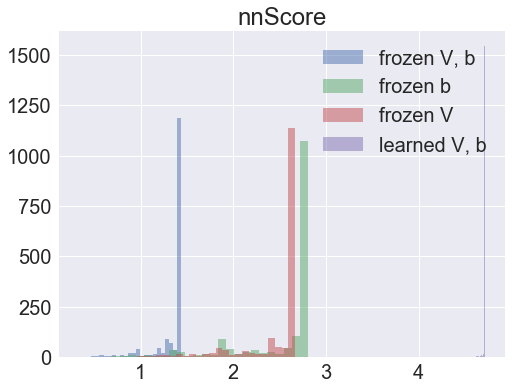

In [17]:
plt.figure(figsize=(8,6));
plt.hist(nnScore(XTr, wFVBNN, R, b, g),bins=25,alpha=0.5);
plt.hist(nnScore(XTr, wFBNN, VFBNN, bFBNN, g),bins=25,alpha=0.5);
plt.hist(nnScore(XTr, wFVNN, VFVNN, bFVNN, g),bins=25,alpha=0.5);
plt.hist(nnScore(XTr, wNN, VNN, bNN, g),bins=25,alpha=0.5);
plt.title('nnScore');
plt.legend(['frozen V, b', 'frozen b', 'frozen V', 'learned V, b']);

# plt.hist(np.sum(hiddenScore(XTr, R, g)**2, axis = 0), bins = 100, alpha = 0.5);
# plt.hist(np.sum(fhiddenScore(XTr, VFNN, bFNN, g)**2, axis = 0), bins = 100, alpha = 0.5);

## Background contrast optimisation

In [18]:
from myBGContraster import *

lrnBG = MyBGContraster(nu)
lrnBG.fit(XTrTrans, XBG)

In [19]:
wBG = lrnBG.w
rBG = lrnBG.r

## sklearn optimisation

In [20]:
ocSKL = OneClassSVM(nu = nu, kernel = 'linear')
ocSKL.fit(XTrTrans)

#ocSKL = OneClassSVM(nu = nu, kernel = 'rbf', gamma = gMed)
#ocSKL.fit(XTr)

#print(ocsvm_grad(np.concatenate([ ocSKL.coef_/(nu * XTr.shape[0]), [ ocSKL.intercept_/(nu * XTr.shape[0]) ] ]).flatten(), XTr, nu, D))

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto',
      kernel='linear', max_iter=-1, nu=0.75, random_state=None,
      shrinking=True, tol=0.001, verbose=False)

## Comparison of predictions

In [22]:
ocSKLScores   = (ocSKL.decision_function(XTeTrans).flatten())/(nu * XTr.shape[0])
ocEXPScores   = svmScore(XTeTrans, wEXP) - rEXP

ocFVBNNScores = nnScore(XTe, wFVBNN, R, b, g) - rFVBNN
ocFBNNScores  = nnScore(XTe, wFBNN, VFBNN, bFBNN, g) - rFBNN
ocFVNNScores  = nnScore(XTe, wFVNN, VFVNN, bFVNN, g) - rFVNN
ocNNScores    = nnScore(XTe, wNN, VNN, bNN, g) - rNN

ocBGScores    = XTeTrans.dot(wBG) - rBG

In [23]:
# plt.figure(figsize = (8,6));
# plt.hist(ocEXPScores - ocSKLScores, bins = 25);
# plt.title('skl vs OC-SVM explicit');

In [24]:
# plt.figure(figsize = (8,6));
# plt.hist(ocNNScores - ocSKLScores, bins = 25);
# plt.title('skl vs OC-NN frozen V');

In [25]:
# plt.figure(figsize = (8,6));
# plt.hist(ocNNScores - ocEXPScores, bins = 25);
# plt.title('OC-SVM explicit vs OC-NN frozen V');

In [26]:
# plt.figure(figsize = (8,6));
# plt.hist(ocFNNScores - ocSKLScores, bins = 25);
# plt.title('skl vs OC-NN learned V');

In [27]:
# plt.figure(figsize = (8,6));
# plt.hist(ocBGScores - ocSKLScores, bins = 25);
# plt.title('skl vs background contrast');

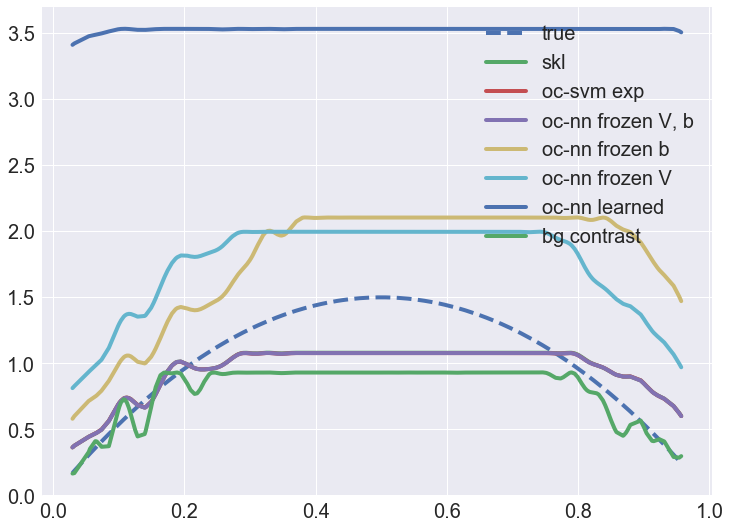

In [28]:
plt.figure(figsize = (12, 9));
plt.plot(XTe, pStar(XTe), '--', linewidth = 4)
plt.plot(XTe, nu * (ocSKLScores - ocSKL.intercept_/(nu*XTr.shape[0])), linewidth = 4)
plt.plot(XTe, nu * (ocEXPScores + rEXP), linewidth = 4)

plt.plot(XTe, nu * (ocFVBNNScores + rFVBNN), linewidth = 4)
plt.plot(XTe, nu * (ocFBNNScores + rFBNN), linewidth = 4)
plt.plot(XTe, nu * (ocFVNNScores + rFVNN), linewidth = 4)
plt.plot(XTe, nu * (ocNNScores + rNN), linewidth = 4)

plt.plot(XTe, ocBGScores + rBG, linewidth = 4)

plt.legend(['true', 
            'skl', 
            'oc-svm exp', 
            'oc-nn frozen V, b', 
            'oc-nn frozen b', 
            'oc-nn frozen V',             
            'oc-nn learned', 
            'bg contrast'],
          loc = 'upper right');